#### Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [226]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers , models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img


In [227]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [228]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./data/Train")
data_dir_test = pathlib.Path("./data/Test")

In [229]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [230]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [231]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# Create the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Use 20% of the data for validation
    subset="training",
    seed=123,  # Seed for reproducibility
    image_size=(img_height, img_width),  # Resize images to the target size
    batch_size=batch_size
)

# Print the class names
class_names = train_ds.class_names
print("Class names:", class_names)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [232]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # Use 20% of the data for validation
    subset="validation",
    seed=123,  # Seed for reproducibility
    image_size=(img_height, img_width),  # Resize images to the target size
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [233]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

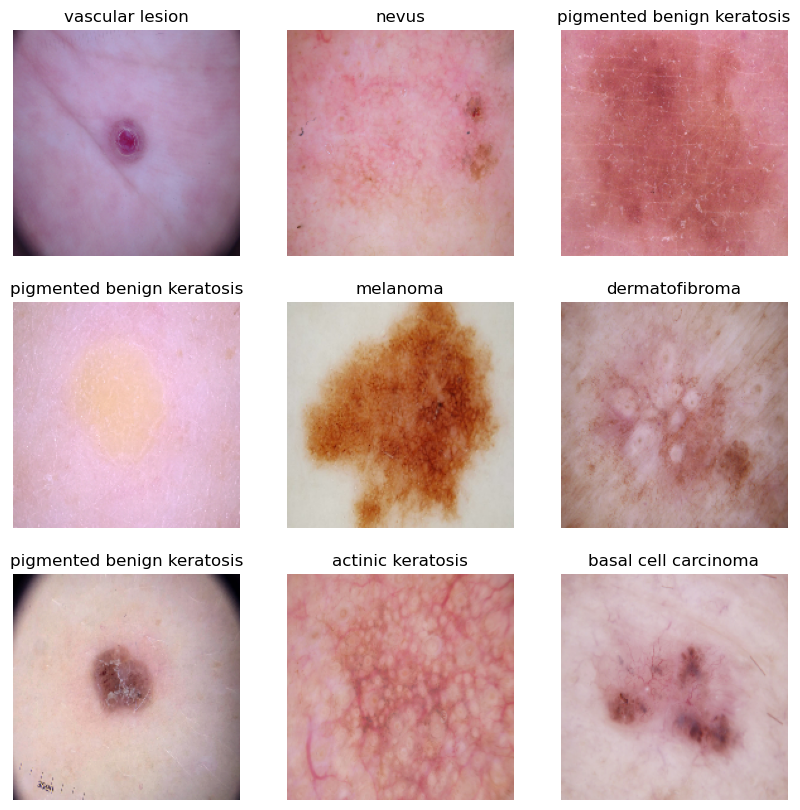

In [234]:
# Visualize some images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Take one batch from the dataset
    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [235]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [236]:

# Define the model
model = models.Sequential([
    # Normalize pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # First convolutional layer
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Second convolutional layer
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Third convolutional layer
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    layers.Flatten(),

    # 512 neuron hidden layer
    layers.Dense(512, activation='relu'),

    # Output layer with 9 classes

    layers.Dense(9, activation='sigmoid')

])


### Compile the model
Optimiser and loss function for model training 

In [237]:
###  Appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [238]:
# View the summary of all layers
model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_26 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_81 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_82 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_83 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 512)            │    15,860,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,888,425 (60.61 MB)

 Trainable params: 15,888,425 (60.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [239]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.2334 - loss: 2.3495 - val_accuracy: 0.4474 - val_loss: 1.6368
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.4432 - loss: 1.5764 - val_accuracy: 0.5213 - val_loss: 1.4366
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - accuracy: 0.5113 - loss: 1.3867 - val_accuracy: 0.4989 - val_loss: 1.4114
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.5625 - loss: 1.2655 - val_accuracy: 0.5570 - val_loss: 1.3689
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.5829 - loss: 1.1788 - val_accuracy: 0.5347 - val_loss: 1.3608
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.6116 - loss: 1.1276 - val_accuracy: 0.5190 - val_loss: 1.3913
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.6108 - loss: 1.0288 - val_accuracy: 0.5235 - val_loss: 1.4124
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.6893 - loss: 0.8647 - val_accuracy: 

### Visualizing training results

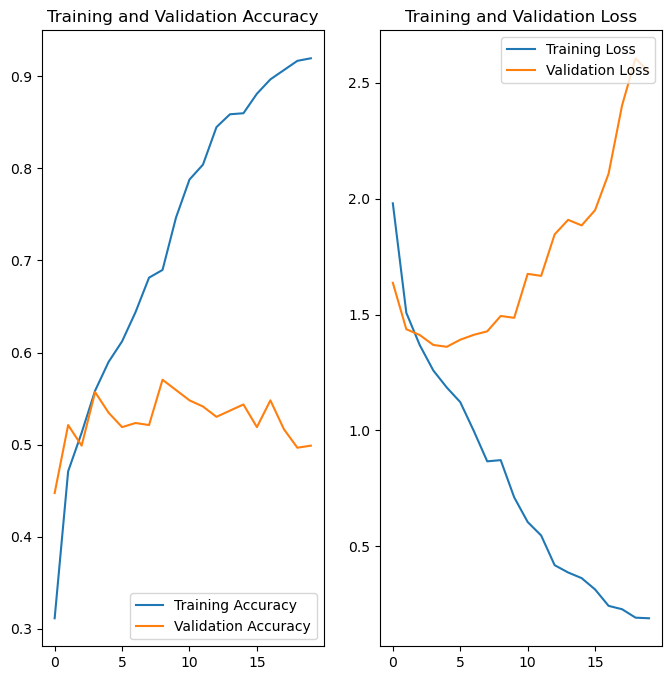

In [240]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Findings

The model is overfitting. The training accuracy is high, but the validation accuracy is low. The potential issues might be
Regularization:-
1) Dropout is a regularization technique that helps prevent overfitting.
2) Increase the diversity of your training data by applying random transformations
3) Stop training when the validation loss stops improving.
4) Simplify your model by reducing the number of layers or the number of units in each layer.
5) Batch normalization can also act as a regularizer to reduce overfitting.
 

### Write your findings here

In [241]:
# Data augumentation strategy. 

# Define the data augmentation strategy
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Use 20% of the data for validation

)

# Apply the data augmentation to the training dataset
train_generator = data_augmentation.flow_from_directory(
    './data/Train',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset="training"
)


# Apply the data augmentation to the validation dataset
validation_generator = data_augmentation.flow_from_directory(
    './data/Train',
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='sparse',
    subset="validation"
)



Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


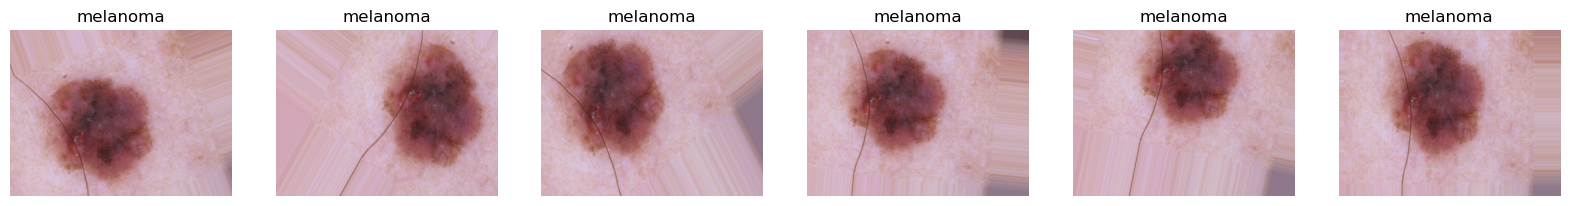

In [242]:
# Load a sample image
img_path = './data/Train/melanoma/ISIC_0000139.jpg'  # Replace with the path to your sample image
img = load_img(img_path)
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# Generate augmented images and visualize them
fig, ax = plt.subplots(1, 6, figsize=(20, 20))
for i, batch in enumerate(data_augmentation.flow(x, batch_size=1)):
    ax[i].imshow(batch[0])
    ax[i].set_title('melanoma')  
    ax[i].axis('off')
    if i == 5:  # Show 5 augmented images
        break

plt.show()

#### Create the model, compile and train the model

In [243]:

## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here

model = models.Sequential([

  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),


  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),

  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),

  layers.Conv2D(256, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),

  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(256, activation=tf.nn.relu),

  layers.Dense(9, activation='softmax')
])



#### Compiling the model

In [244]:

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_27 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 90, 90, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 45, 45, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 22, 22, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 22, 22, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_87 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │     7,930,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,105,193 (30.92 MB)

 Trainable params: 8,104,457 (30.92 MB)

 Non-trainable params: 736 (2.88 KB)

#### Training the model

In [245]:
%%time
# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with the EarlyStopping callback
epochs = 20

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 471ms/step - accuracy: 0.2687 - loss: 5.5895 - val_accuracy: 0.1599 - val_loss: 3.6425
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 453ms/step - accuracy: 0.3810 - loss: 1.7958 - val_accuracy: 0.0811 - val_loss: 5.3731
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 453ms/step - accuracy: 0.4142 - loss: 1.6300 - val_accuracy: 0.0811 - val_loss: 6.6424
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 453ms/step - accuracy: 0.4811 - loss: 1.5104 - val_accuracy: 0.0811 - val_loss: 6.7488
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 453ms/step - accuracy: 0.5036 - loss: 1.5358 - val_accuracy: 0.1689 - val_loss: 7.3606
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 463ms/step - accuracy: 0.4863 - loss: 1.4709 - val_accuracy: 0.0676 - val_loss: 5.9405
CPU times: user 8min 25s, sys: 1min 1s, total: 9min 27s
Wall time: 2min 38s


range(0, 6)
[0.31977716088294983, 0.4072423279285431, 0.4261838495731354, 0.4774373173713684, 0.5025069713592529, 0.49080780148506165]


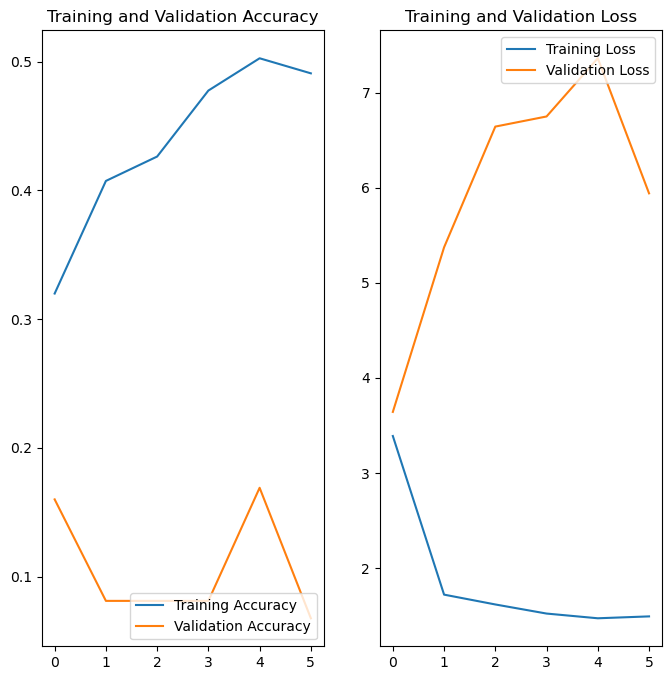

In [246]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

print(epochs_range)
print(acc)


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


#### Observations:

The model is underfitting, as indicated by the low validation accuracy and high validation loss.
The training and validation data are showing poor performance
The model overfitting issue addressed and model is underfitting.

To address this, let's look at the class imbalance  

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Class Names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Class Distribution (Count):
vascular lesion: 115
nevus: 277
pigmented benign keratosis: 370
melanoma: 352
dermatofibroma: 77
actinic keratosis: 92
basal cell carcinoma: 309
squamous cell carcinoma: 142
seborrheic keratosis: 58
------------------------------------------------------
Class Distribution (Percentage):
vascular lesion: 6.42%
nevus: 15.46%
pigmented benign keratosis: 20.65%
melanoma: 19.64%
dermatofibroma: 4.30%
actinic keratosis: 5.13%
basal cell carcinoma: 17.24%
squamous cell carcinoma: 7.92%
seborrheic keratosis: 3.24%
------------------------------------------------------


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


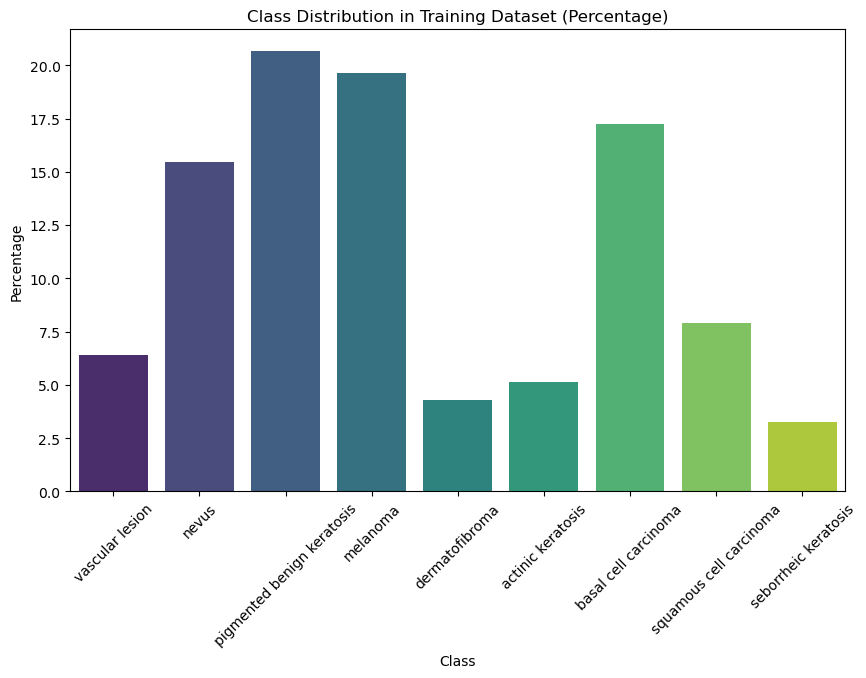

In [247]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Define image size and batch size
img_height = 180
img_width = 180
batch_size = 32

# Load the training dataset
data_dir_train = "./data/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get the class names
class_names = train_ds.class_names
print("Class Names:", class_names)

# Count the occurrences of each class
class_counts = Counter()
for images, labels in train_ds:
    class_counts.update(labels.numpy())

# Convert counts to percentages
total_samples = sum(class_counts.values())
class_percentages = {class_names[int(k)]: (v / total_samples) * 100 for k, v in class_counts.items()}

# Print the class distribution counts

print("Class Distribution (Count):")
for index, count in class_counts.items():
    print(f"{class_names[int(index)]}: {count}")


# Print the class distribution percentages
print("------------------------------------------------------")
print("Class Distribution (Percentage):")

for class_name, percentage in class_percentages.items():
    print(f"{class_name}: {percentage:.2f}%")
print("------------------------------------------------------")
# Plot the distribution of classes
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_percentages.keys()), y=list(class_percentages.values()), palette="viridis")
plt.title('Class Distribution in Training Dataset (Percentage)')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

#### Findings here: 
#### - Which class has the least number of samples?

The seborrheic keratosis got least number which 3.24% .

#### - Which classes dominate the data in terms proportionate number of samples?

"Pigmented benign keratosis" and "melanoma" are dominating other classes, approximately 20.65% and 19.64% of the data, respectively.

#### Observations:

This is very clear that class imbalance seen in the training data.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [248]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [249]:
path_to_training_dataset="./data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.



Initialised with 114 image(s) found.
Output directory set to ./data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x36AB78F50>: 100%|██████████| 500/500 [00:01<00:00, 369.93 Samples/s]


Initialised with 376 image(s) found.
Output directory set to ./data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3908E8950>: 100%|██████████| 500/500 [00:01<00:00, 406.91 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to ./data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3A5CB0450>: 100%|██████████| 500/500 [00:01<00:00, 391.53 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to ./data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x3B380A310>: 100%|██████████| 500/500 [00:06<00:00, 80.50 Samples/s]                    


Initialised with 357 image(s) found.
Output directory set to ./data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x36AB7A290>: 100%|██████████| 500/500 [00:04<00:00, 101.41 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to ./data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x391394C10>: 100%|██████████| 500/500 [00:01<00:00, 368.55 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to ./data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x38BA73010>: 100%|██████████| 500/500 [00:02<00:00, 174.57 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to ./data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3A5C98F50>: 100%|██████████| 500/500 [00:01<00:00, 336.07 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to ./data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3A5D5CAD0>: 100%|██████████| 500/500 [00:01<00:00, 343.85 Samples/s]                  


In [250]:
data_dir_train = pathlib.Path(data_dir_train)
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)


4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [251]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['data/Train/melanoma/output/melanoma_original_ISIC_0000484.jpg_4c380b64-ca6d-4e41-9f45-f2c43c015802.jpg',
 'data/Train/melanoma/output/melanoma_original_ISIC_0000164.jpg_9d2fad64-6ddc-4431-a2da-6736a56f8937.jpg',
 'data/Train/melanoma/output/melanoma_original_ISIC_0010478.jpg_e701e7b3-605d-4c09-b893-514a309136ac.jpg',
 'data/Train/melanoma/output/melanoma_original_ISIC_0000552.jpg_982ea49b-6a08-4c6c-9195-2a91517055d5.jpg',
 'data/Train/melanoma/output/melanoma_original_ISIC_0000292.jpg_071807ac-c743-4759-8abd-0ffdf60eeedc.jpg',
 'data/Train/melanoma/output/melanoma_original_ISIC_0011169.jpg_4c7ec03c-0d97-4547-9ff3-a813f2ba31cd.jpg',
 'data/Train/melanoma/output/melanoma_original_ISIC_0009971.jpg_704abd11-76ea-479f-8af1-5d07b7223054.jpg',
 'data/Train/melanoma/output/melanoma_original_ISIC_0000533.jpg_f7e0c685-eac7-46e3-8d8c-e59eb7f256dd.jpg',
 'data/Train/melanoma/output/melanoma_original_ISIC_0010000.jpg_d383f68e-cd77-4c83-a89e-b6cea86d1a55.jpg',
 'data/Train/melanoma/output/melanoma

In [252]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [253]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [254]:
# Count the Total Number of Augmented Images Generated by Augmentor

# Count the number of image files in the 'output' subdirectories of each class
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))

# Print the total count of augmented images
print("Total number of augmented images:", image_count_train)

Total number of augmented images: 4500


Train the model on the data created using Augmentor

In [255]:
batch_size = 32
img_height = 180
img_width = 180


Create a training dataset

In [256]:
# data_dir_train="path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Create a validation dataset

In [257]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Create your model (make sure to include normalization)

In [258]:
augmentation_data = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

In [259]:
## your code goes here

model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(9, activation='softmax')
])

Compile your model (Choose optimizer and loss function appropriately)

In [260]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train your model

In [261]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/opt/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:678: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 32s 176ms/step - accuracy: 0.2427 - loss: 3.9972 - val_accuracy: 0.1084 - val_loss: 24.9237
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 174ms/step - accuracy: 0.2947 - loss: 1.8874 - val_accuracy: 0.1151 - val_loss: 8.3382
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.3694 - loss: 1.6851 - val_accuracy: 0.3385 - val_loss: 1.9075
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 171ms/step - accuracy: 0.4191 - loss: 1.5402 - val_accuracy: 0.4113 - val_loss: 1.5606
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.4622 - loss: 1.4266 - val_accuracy: 0.4128 - val_loss: 1.5326
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 171ms/step - accuracy: 0.4781 - loss: 1.3630 - val_accuracy: 0.3437 - val_loss: 1.8342
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.4754 - loss: 1.3302 - val_accuracy: 0.4165 - val_loss: 1.5200
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 172ms/step - accuracy: 0.4929 - loss: 1.2752 - va

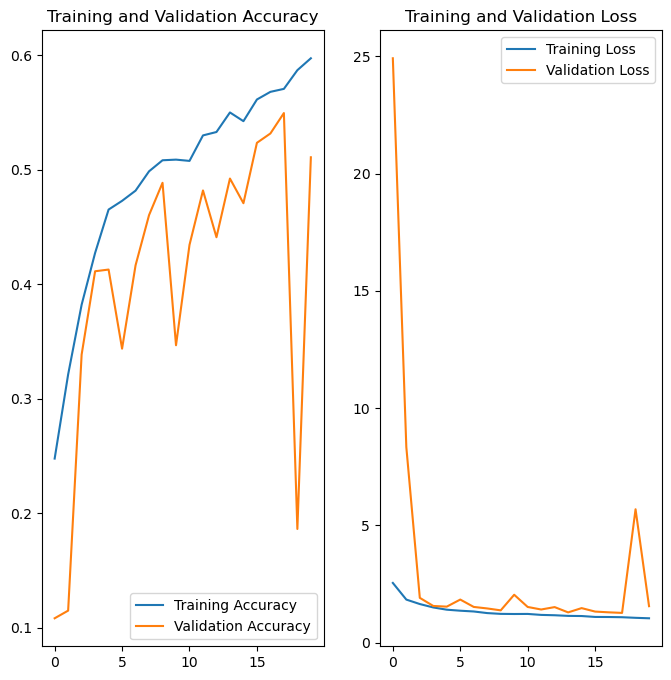

In [262]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observation:

It looks like model is showing some improvement, but there is still a gap between training and validation accuracy, which might indicate some overfitting. 
To further improve the model, we can try the following steps:

The ReduceLROnPlateau callback in Keras is used to reduce the learning rate when a metric has stopped improving. This can help the model converge more effectively by reducing the learning rate when the model reaches a plateau.

In [263]:
model = Sequential()
model.add(layers.Rescaling(1./255,input_shape=(180,180,3))) 
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [264]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [265]:
# View the summary of all layers
model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_29 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_91 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_91 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_92 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_92 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_93 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_93 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 10, 10, 256)    │     3,965,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_94 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,738,825 (21.89 MB)

 Trainable params: 5,738,825 (21.89 MB)

 Non-trainable params: 0 (0.00 B)

In [266]:
%%time
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 62s 363ms/step - accuracy: 0.1552 - loss: 2.1947 - val_accuracy: 0.1722 - val_loss: 2.1024 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 1019s 6s/step - accuracy: 0.2259 - loss: 1.9783 - val_accuracy: 0.2390 - val_loss: 2.0215 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 597s 4s/step - accuracy: 0.2920 - loss: 1.7977 - val_accuracy: 0.3846 - val_loss: 1.5357 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 386ms/step - accuracy: 0.3435 - loss: 1.6981 - val_accuracy: 0.3860 - val_loss: 1.5342 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 360ms/step - accuracy: 0.3759 - loss: 1.5673 - val_accuracy: 0.4380 - val_loss: 1.4156 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 361ms/step - accuracy: 0.4084 - loss: 1.4945 - val_accuracy: 0.4254 - val_loss: 1.5336 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 60s 357ms/step - accuracy: 0.4451

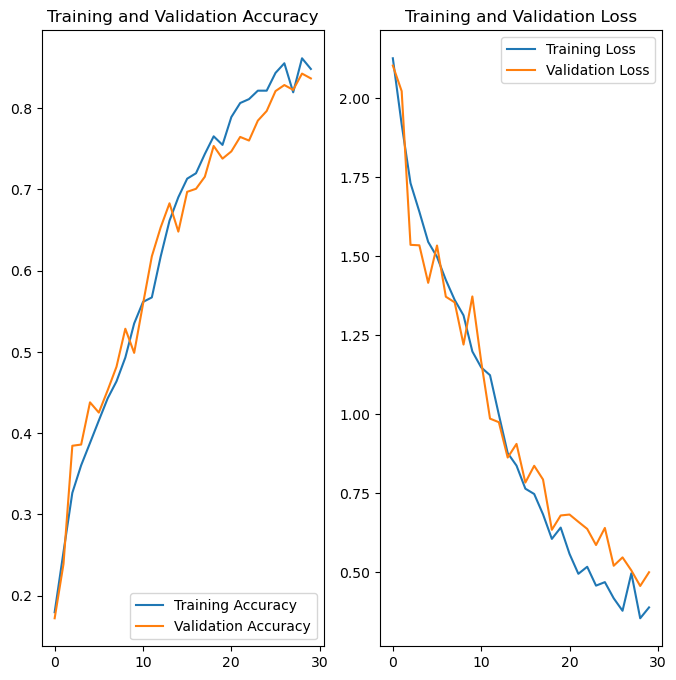

In [268]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Observations:

The final model showcases well-balanced performance, displaying no signs of underfitting or overfitting.

The implementation of class rebalancing has enhanced the model's performance in both training and validation datasets.

In total 30 epochs, the final model attains an accuracy of 85% on the training set and 83% on the validation set.


The addition of batch normalization failed to enhance both training and validation accuracy.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Actual Class: actinic keratosis
Predicted Class: actinic keratosis


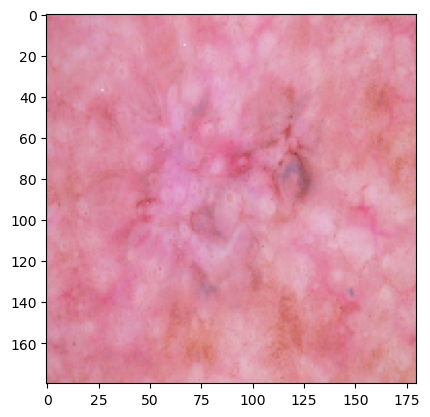

In [269]:
from glob import glob

# Construct the path to a test image
test_image_path = os.path.join(data_dir_test, class_names[0], '*')

# Get a list of all test images for the selected class
test_images = glob(test_image_path)

# Load the last test image in the list
test_image = load_img(test_images[-1], target_size=(180, 180, 3))

# Display the test image
plt.imshow(test_image)
plt.grid(False)

# Expand dimensions to match the input shape of the model
img = np.expand_dims(test_image, axis=0)

# Make predictions using the trained model
pred = model.predict(img)

# Get the index of the predicted class with the highest probability
pred = np.argmax(pred)

# Get the predicted class name
pred_class = class_names[pred]

# Print the actual and predicted class names
print("Actual Class: " + class_names[0])
print("Predicted Class: " + pred_class)